# Evaluation of learning pipeline

**Author**: Miguel Xochicale [@mxochicale](https://github.com/mxochicale)     
**Contributors**: Nhat Phung Tran Huy [@huynhatd13](https://github.com/huynhatd13); Hamideh Kerdegari [@hamidehkerdegari](https://github.com/hamidehkerdegari);  Alberto Gomez [@gomezalberto](https://github.com/)  

Feb2022; March2022 


## Summary
This notebook presents a learning pipeline to classify 4 chamber view from echocardiography datasets.

### How to run the notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server  
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
### References
* "Proposed Regulatory Framework for Modifications to Artificial Intelligence/Machine Learning (AI/ML)-Based Software as a Medical Device (SaMD) - Discussion Paper and Request for Feedback". https://www.fda.gov/media/122535/download 
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 
* Kerdegari H. et al. 2021 https://github.com/vital-ultrasound/lung/tree/main/multiclass_tensorflow



# Jupyter Notebook

## 1. Setting imports and datasets paths

In [1]:
import os
import sys
import argparse
import yaml

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from IPython.display import HTML #to be used with HTML(animation.ArtistAnimation().to_jshtml())
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchinfo import summary
from torchvision import transforms, utils, models

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
#from source.models.learning_misc import train_loop, test_loop, basicVGGNet
from source.helpers.various import concatenating_YAML_via_tags, plot_dataset_classes, split_train_validate_sets

HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]
REPOSITORY_PATH='repositories/echocardiography'
FULL_REPO_PATH = HOME_PATH+'/'+REPOSITORY_PATH
FULL_REPO_MODEL_PATH = HOME_PATH +'/' + REPOSITORY_PATH + '/models'

CONFIG_FILES_PATH= REPOSITORY_PATH + '/scripts/config_files/users_paths_files'
YML_FILE =  'config_users_paths_files_username_' + USERNAME + '.yml'
FULL_PATH_FOR_YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, YML_FILE)

yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler
with open(FULL_PATH_FOR_YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)
    
    
print(f'PyTorch Version: {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')    
print(f'FULL_PATH_FOR_YML_FILE: {FULL_PATH_FOR_YML_FILE}' )

PyTorch Version: 1.9.0
Torchvision Version: 0.10.0a0
FULL_PATH_FOR_YML_FILE: /home/mx19/repositories/echocardiography/scripts/config_files/users_paths_files/config_users_paths_files_username_mx19.yml


## 2. Setting variables and loading datasets using pytorch dataloader

In [2]:
# device = torch.device(if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # "cuda:NN" can also be used
print(f'Device: {device}')

pretransform_im_size = config['pretransform_im_size']

# Defining transforms that apply to the entire dataset.
# These transforms are not augmentation.
if config['use_pretransform_image_size']:
    pretransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=pretransform_im_size),
        transforms.ToTensor(),
    ])
else:
    pretransform = None

# These transforms have random parameters changing at each epoch.
if config['use_train_augmentation']:
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),  # in degrees
        transforms.RandomEqualize(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(), 
    ])
else:
    transform = None
    
# These transforms have random parameters changing at each epoch.
if config['use_validation_augmentation']:
    val_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=5),  # in degrees
    #transforms.RandomEqualize(p=0.5),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ToTensor(), 
    ])
else:
    transform = None


train_dataset = EchoClassesDataset(
    main_data_path=config['main_data_path'],
    participant_videos_list=config['participant_videos_list_train'],
    participant_path_json_list=config['participant_path_json_list_train'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    number_of_frames_per_segment_in_a_clip=config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=device,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    pretransform=pretransform,
    transform=train_transform,
    use_tmp_storage=True,
    )

validation_dataset = EchoClassesDataset(
    main_data_path=config['main_data_path'],
    participant_videos_list=config['participant_videos_list_validation'],
    participant_path_json_list=config['participant_path_json_list_validation'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    number_of_frames_per_segment_in_a_clip=config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=device,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    pretransform=pretransform,
    transform=val_transform,
    use_tmp_storage=True,
    )


## Spliting train_dataset into train_set and test_set
Ntdt = train_dataset.__len__()
ntraining = 0.9

Ntrain=round(Ntdt*ntraining)
Ntest = round(Ntdt - (Ntdt*ntraining))
print(Ntrain, Ntest, Ntrain+Ntest)
train_set, test_set = torch.utils.data.random_split(train_dataset, [Ntrain, Ntest])


Device: cuda
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-074/T3/01NVb-003-074-3-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T1/01NVb-003-077-1-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T2/01NVb-003-077-2-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T3/01NVb-003-077-3-4CV.json (empty). Removing from list
169 19 188


## 3. Plotting Class Distribution

{'BKGR': 86, '4CV': 83}
{'BKGR': 13, '4CV': 13}
{'BKGR': 8, '4CV': 11}
Number of frames for training datasets 10140
Number of frames for testing datasets 1140


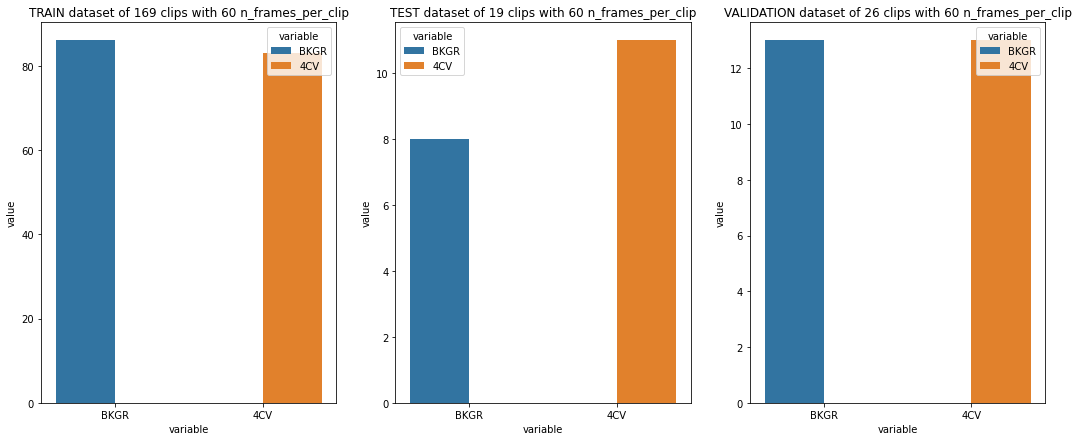

In [3]:
label_id = ('BKGR', '4CV')
number_of_frames_per_segment_in_a_clip = config['number_of_frames_per_segment_in_a_clip'] 

def get_class_distribution(dataset_obj):
    count_class_dict = {
   'BKGR': 0 ,
   "4CV": 0
    }
    
    for clip_index_i in range(len(dataset_obj)):
        data_idx = dataset_obj[clip_index_i]
        label_id_idx = data_idx[1]
        label = label_id[label_id_idx]
        count_class_dict[label]+= 1
        #count_class_dict[label]+= 1* number_of_frames_per_segment_in_a_clip

    return count_class_dict
        
        
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), 
                       x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)


print(get_class_distribution(train_set))
print(get_class_distribution(validation_dataset))
print(get_class_distribution(test_set))
    
number_of_frames_per_segment_in_a_clip = config['number_of_frames_per_segment_in_a_clip']    
print(f'Number of frames for training datasets {Ntrain*number_of_frames_per_segment_in_a_clip}')
print(f'Number of frames for testing datasets {Ntest*number_of_frames_per_segment_in_a_clip}')
#print(f'Number of frames for training datasets {Ntrain*number_of_frames_per_segment_in_a_clip}')

plot_title_train_label= f'TRAIN dataset of {len(train_set)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'
plot_title_test_label= f'TEST dataset of {len(test_set)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'
plot_title_val_label= f'VALIDATION dataset of {len(validation_dataset)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7))
plot_from_dict(get_class_distribution(train_set), plot_title=plot_title_train_label, ax=axes[0])
plot_from_dict(get_class_distribution(test_set), plot_title=plot_title_test_label, ax=axes[1])
plot_from_dict(get_class_distribution(validation_dataset), plot_title=plot_title_val_label, ax=axes[2])
plt.show()

###########
## NOTES ##
# HamidehK on Thu 23 Mar 14:00:00 GMT 2022
    # 65 clips with 60 frames each create 3900 frames which is a low number for traininig data.
    # Hamideh recomends to increase the training data or perhaps reduce the convs to one!

# MiguelX on Mon 28 Mar 11:35:55 BST 2022
    # Make use of 169 clips with 60 frames which results in 10140 frames for training data.


## 5. Displayting frames in the dataloader

In [4]:
##############################
##### Setting up BATCH_SIZE_OF_CLIPS
BATCH_SIZE_OF_CLIPS = 4
##############################
##############################

print(f' train_dataset.__len__() = {train_set.__len__()}')
train_dataloader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True,
    num_workers=0)

print(f' test_dataset.__len__() = {test_set.__len__()}')
test_dataloader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

print(f' validation_dataset.__len__() = {validation_dataset.__len__()}')
val_dataloader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

print(f'====================================================')
print(f'len(train_dataloader): {len(train_dataloader)}')
for clip_batch_idx, sample_batched in enumerate(train_dataloader):
    print(f'  ====================================================')
    sample_batched_images=sample_batched[0]
    sample_batched_labels=sample_batched[1]
    print(f'    BATCH_OF_CLIPS_INDEX : {clip_batch_idx} / {len(train_dataloader) - 1}')
    print(f'    sample_batched_labels.size(): {  sample_batched_labels.size()  }')
    print(f'    sample_batched_labels.squeeze().size(): {  sample_batched_labels.squeeze().size()  }')
    print(f'    sample_batched_images.size(): {sample_batched_images.size()}')

    for BATCH_SIZE_IDX, label in enumerate(sample_batched_labels):
        print(f'        BATCH_SIZE_IDX {BATCH_SIZE_IDX} label: {label}')
        sample_batched_idx_image = sample_batched_images[BATCH_SIZE_IDX,...]
        print(f'        Sample_batched_idx_image.size()  {sample_batched_idx_image.size() }'  )

        grid = utils.make_grid(sample_batched_idx_image)
        print(f'        Grid size {grid.size()}' )
#         plt.figure(figsize =(20,20) )
#         plt.imshow( grid.cpu().detach().numpy().transpose(1, 2, 0) )
#         plt.title(f'BATCH_SIZE_IDX {BATCH_SIZE_IDX}; Label: {label_id[label]}')
#         plt.axis('off')
#         plt.ioff()
#         plt.show()



 train_dataset.__len__() = 169
 test_dataset.__len__() = 19
 validation_dataset.__len__() = 26
len(train_dataloader): 43
    BATCH_OF_CLIPS_INDEX : 0 / 42
    sample_batched_labels.size(): torch.Size([4])
    sample_batched_labels.squeeze().size(): torch.Size([4])
    sample_batched_images.size(): torch.Size([4, 1, 60, 128, 128])
        BATCH_SIZE_IDX 0 label: 1
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 1 label: 1
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 2 label: 0
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 3 label: 1
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
    BATCH_OF_CLIPS_INDEX : 1 / 42
    sample_batched_labels.size(): 

    BATCH_OF_CLIPS_INDEX : 11 / 42
    sample_batched_labels.size(): torch.Size([4])
    sample_batched_labels.squeeze().size(): torch.Size([4])
    sample_batched_images.size(): torch.Size([4, 1, 60, 128, 128])
        BATCH_SIZE_IDX 0 label: 0
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 1 label: 1
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 2 label: 0
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 3 label: 1
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
    BATCH_OF_CLIPS_INDEX : 12 / 42
    sample_batched_labels.size(): torch.Size([4])
    sample_batched_labels.squeeze().size(): torch.Size([4])
    sample_batched_images.size(): torch.Siz

    BATCH_OF_CLIPS_INDEX : 22 / 42
    sample_batched_labels.size(): torch.Size([4])
    sample_batched_labels.squeeze().size(): torch.Size([4])
    sample_batched_images.size(): torch.Size([4, 1, 60, 128, 128])
        BATCH_SIZE_IDX 0 label: 0
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 1 label: 1
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 2 label: 0
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 3 label: 1
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
    BATCH_OF_CLIPS_INDEX : 23 / 42
    sample_batched_labels.size(): torch.Size([4])
    sample_batched_labels.squeeze().size(): torch.Size([4])
    sample_batched_images.size(): torch.Siz

    BATCH_OF_CLIPS_INDEX : 34 / 42
    sample_batched_labels.size(): torch.Size([4])
    sample_batched_labels.squeeze().size(): torch.Size([4])
    sample_batched_images.size(): torch.Size([4, 1, 60, 128, 128])
        BATCH_SIZE_IDX 0 label: 1
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 1 label: 0
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 2 label: 0
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 3 label: 0
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
    BATCH_OF_CLIPS_INDEX : 35 / 42
    sample_batched_labels.size(): torch.Size([4])
    sample_batched_labels.squeeze().size(): torch.Size([4])
    sample_batched_images.size(): torch.Siz

## 6. Define networks

In [5]:
################################
##### Define VGG00 architecture
class VGG00(nn.Module):

    def __init__(self, input_size, n_classes=2):
        """
        Simple Video classifier to classify into two classes:
        Args:
            input_size:  shape of the input image. Should be a 2 element vector for a 2D video (width, height) [e.g. 128, 128].
            n_classes: number of output classes
        """

        super(VGG00, self).__init__()
        self.name = 'VGG00'
        self.input_size = input_size
        self.n_classes = n_classes
        self.n_frames_per_clip = config['number_of_frames_per_segment_in_a_clip']
        self.n_features = np.prod(self.input_size)*self.n_frames_per_clip

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()
        
        self.conv0 = nn.Conv3d(in_channels=1, out_channels=64,
                               kernel_size = (1, 3, 3),  ## (-depth, -height, -width)
                               stride =      (4, 3, 3), ##(depth/val0, height/val1, width/val2)
                               padding =     (0, 0, 0)
                               )
        #NOTES
        #https://pytorch.org/docs/stable/generated/torch.nn.Conv3d.html
        #IN: [N,Cin,D,H,W]; OUT: (N,Cout,Dout,Hout,Wout)
        #[batch_size, channels, depth, height, width].

        self.conv1 = nn.Conv3d(in_channels=64, out_channels=128,
                               kernel_size = (1, 3, 3),  # (-depth, -height, -width)
                               stride =      (4, 3, 3), ##(depth/val0, height/val1, width/val2)
                               padding =     (0, 0, 0)
                               )
        
#         self.conv2 = nn.Conv3d(in_channels=128, out_channels=256,
#                                kernel_size =  (1, 3, 3),  # (-depth, -height, -width)
#                                stride =       (1, 3, 3), ##(depth/val0, height/val1, width/val2)
#                                padding =      (0, 0, 0)
#                                )
        
        
#         self.conv3 = nn.Conv3d(in_channels=256, out_channels=512,
#                                kernel_size=(2, 2, 2),  # (-depth, -height, -width)
#                                stride=(2, 2, 2), ##(depth/val0, height/val1, width/val2)
#                                padding = (0, 0, 0)
#                                )
        
        
#         self.pool0 = nn.MaxPool3d(
#                                 kernel_size = (1, 3, 3),  # (-depth, -height, -width)
#                                 stride =      (1, 1, 1), 
#                                 padding =     (0, 0, 0), 
#                                 dilation =    (1, 1, 1)
#                                 )
#         #NOTES
#         #Keeps the training to 50% after 100 epochs


        self.fc0 = nn.Linear(in_features=100352, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=self.n_classes)
        #self.fc1 = nn.Linear(in_features=2048, out_features=self.n_classes)

    def forward(self, x):
        #print(f'x.shape(): {x.size()}') ##[batch_size, channels, depth, height, width]
        
        x = F.relu( self.conv0(x) )
        #print(f'x.shape(): {x.size()}') #x.shape(): x.shape(): torch.Size([2, 64, 60, 128, 128]) with kernel_size=(1, 1, 1)
        #print(f'x.shape(): {x.size()}') #x.shape():torch.Size([2, 64, 51, 29, 29]) with kernel_size=(10, 100, 100)
        #print(f'conv0.size(): {x.size()}')
        
        x = F.relu( self.conv1(x) )
        #print(f'x.shape(): {x.size()}') with kernel_size=(1, 10, 10) #x.shape(): torch.Size([2, 32, 60, 20, 20])
        #print(f'conv1.size(): {x.size()}')
        
        #x = F.relu( self.conv2(x) )
        #x = F.relu( self.conv3(x) )
        
        #x = self.pool0(x)
        #print(f'x.pool0..shape(): {x.size()}') 
        
        x = self.flatten(x)
        #print(f'self.flatten(x) size() {x.size()}') #x.shape(): torch.Size([4, 983040])
        x = self.fc0(x)
        #print(f'x.shape(): {x.size()}') #x.shape(): torch.Size([4, 32])
        #x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        x = F.dropout(x, p=0.5) #dropout was included to combat overfitting
        
        #print(f'x.shape(): {x.size()}') # x.shape(): torch.Size([4, 2])
        #x = self.sigmoid(x)
        
        x = self.softmax(x)
        #print(f'x.shape(): {x.size()}')  #x.shape(): torch.Size([4, 2])

        return x
    

################################
##### Define VGG architecture
class basicVGGNet(nn.Module):

    def __init__(self, tensor_shape_size, n_classes=2, cnn_channels=(1, 16, 32)):
        """
        Simple Visual Geometry Group Network (VGGNet) to classify two US image classes (background and 4CV).

        Args:
            tensor_shape_size: [Batch_clips, Depth, Channels, Height, Depth]

        """
        super(basicVGGNet, self).__init__()
        self.name = 'basicVGGNet'

        self.tensor_shape_size = tensor_shape_size
        self.n_classes = n_classes

        # define the CNN
        self.n_output_channels = cnn_channels ##  self.n_output_channels::: (1, 16, 32)
        self.kernel_size = (3, ) * (len(cnn_channels) -1) ## self.kernel_size::: (3, 3)

        self.n_batch_size_of_clip_numbers = self.tensor_shape_size[0]
        self.n_frames_per_clip = self.tensor_shape_size[1]
        self.n_number_of_image_channels = self.tensor_shape_size[2]
        self.input_shape_tensor = self.n_batch_size_of_clip_numbers * self.n_frames_per_clip * self.n_number_of_image_channels

        self.conv1 = nn.Conv3d(in_channels=self.n_number_of_image_channels, out_channels=64,
                               kernel_size=(1, 1, 1), stride=(1, 1, 1), padding = (0, 0, 0)
                               )
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=2,
                               kernel_size=(1, 1, 1), stride=(1, 1, 1), padding = (0, 0, 0)
                               )
                    #IN: [N,Cin,D,H,W]; OUT: (N,Cout,Dout,Hout,Wout)
                    #[batch_size, channels, depth, height, width].

        self.pool0 = nn.MaxPool3d(kernel_size=(60, 128, 128), stride=(1, 1, 1), padding=(0, 0, 0), dilation=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=(0, 0, 0))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 0, 0))
        self.pool3 = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=(3, 3, 3), padding=(0, 0, 0))
        self.pool4 = nn.MaxPool3d(kernel_size=(16, 16, 16), stride=(16, 16, 16), padding=(0, 0, 0))
        self.pool5 = nn.MaxPool3d(kernel_size=(32, 32, 32), stride=(32, 32, 32), padding=(0, 0, 0))
        self.pool6 = nn.MaxPool3d(kernel_size=(30, 30, 30), stride=(30, 30, 30), padding=(0, 0, 0))
        self.pool7 = nn.MaxPool3d(kernel_size= 60, stride= 60, padding=0)
        self.pool8 = nn.MaxPool3d(kernel_size=(64, 64, 64), stride=(64, 64, 64), padding=(0, 0, 0))
        self.pool9 = nn.MaxPool3d(kernel_size=(128, 128, 128), stride=(128, 128, 128), padding=(0, 0, 0))

        self.bn1 = nn.BatchNorm3d(num_features = 64)
        self.bn2 = nn.BatchNorm3d(num_features = 12)

        self.flatten = nn.Flatten()
        self.fc0 = nn.Linear(in_features=10, out_features=self.n_classes)
        self.fc1 = nn.Linear(in_features=62914560, out_features=self.n_classes)

    def forward(self, x):
        #print(f'x.shape(): {x.size()}') ##[batch_size, channels, depth, height, width]
        
        #x = F.relu(self.bn1(self.conv1(x)))
        #x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv1(x))
        #print(f'x.shape(): {x.size()}')
        x = F.relu(self.conv2(x))
        #print(f'x.shape():: {x.size()}')
        x = self.pool0(x)
        #print(f'x.shape()::: {x.size()}')

        x = self.flatten(x)
        #print(f"After flattening, x.shape: {x.shape}")

        # x = x.reshape(x.shape[0], -1)
        # x = F.dropout(x, p=0.5) #dropout was included to combat overfitting
        #x = self.fc0(x)
        #print(f"After fc1, x.shape: {x.shape}")

        return x    

    
    
###########
## NOTES ##
# Miguel on Mon 28 Mar 15:47:26 BST 2022
    #adding more conv3d might create reduced number of pixel size
    #RuntimeError: Given input size: (256x60x4x4). Calculated output size: (256x60x-5x-5). Output size is too small
    

# Miguel on Thu 24 Mar 09:30:09 GMT 2022
    # Implementations of conv3D are nearly finalised. I will then move on to conv2D with indivial frames to create 
    # sketchs comparison metrics 
        
# Alberto on Thu 22 Mar 09:00:00 GMT 2022
    # The use of conv3D might consume more resources vs conv2D with indivial frames (MX: maybe there is a Trade-off here)
    # For features per frame, AG prototyped the following: 
    #     def forward(self, data):

    #         n_frames = data.shape[2]
    #         features = []
    #         for f in range(n_frames):
    #             feat_i = self.frame_features(data[:, :, f, ...])
    #             features.append(feat_i)

    #         feature_vector = torch.stack(features, dim=1)

    #         out = self.classifier(feature_vector)
    #         return out
    


## 11. Evaluate the model on test dataset

In [6]:
model = VGG00(config['pretransform_im_size']) #print(config['pretransform_im_size']) #(128, 128)
## PRINT MODEL
print(f'====================================================')
print(model)

print(f' {FULL_REPO_MODEL_PATH}')
torch.save(model.state_dict(), os.path.join(FULL_REPO_MODEL_PATH, "metric_model.pth"))
print("Saved metric model")


model.load_state_dict(torch.load(
    #os.path.join(model_path, "VGG00v00_metric_model.pth")
    #os.path.join(model_path, "VGG00v01_metric_model.pth")
    os.path.join(FULL_REPO_MODEL_PATH, "VGG00v02_metric_model.pth")
    ))

model.to(device) # Place model on GPU

model.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for clip_batch_idx, sample_batched in enumerate(test_dataloader):
        X_train_batch, y_train_batch = sample_batched[0].to(device), sample_batched[1].to(device)
        print(f'==================================================')
        print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        y_test_pred = model(X_train_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        
        for i in range(len(y_test_pred)):
            y_true_list.append(y_train_batch[i].cpu().item())
            y_pred_list.append(y_pred_tag[i].cpu().item())
            
        
print(f'==================================================')        
print(f'==================================================')        
print(get_class_distribution(test_set))
print(f'y_pred_list{y_pred_list}')
print(f'y_true_list{y_true_list}')





VGG00(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=None)
  (conv0): Conv3d(1, 64, kernel_size=(1, 3, 3), stride=(4, 3, 3))
  (conv1): Conv3d(64, 128, kernel_size=(1, 3, 3), stride=(4, 3, 3))
  (fc0): Linear(in_features=100352, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=2, bias=True)
)
 /home/mx19/repositories/echocardiography/models
Saved metric model
 BATCH_OF_CLIPS_INDEX: 0 
   X_train_batch.size(): torch.Size([4, 1, 60, 128, 128])
   y_train_batch.size(): torch.Size([4])


/tmp/ipykernel_45475/3550200339.py:99: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


 BATCH_OF_CLIPS_INDEX: 1 
   X_train_batch.size(): torch.Size([4, 1, 60, 128, 128])
   y_train_batch.size(): torch.Size([4])
 BATCH_OF_CLIPS_INDEX: 2 
   X_train_batch.size(): torch.Size([4, 1, 60, 128, 128])
   y_train_batch.size(): torch.Size([4])
 BATCH_OF_CLIPS_INDEX: 3 
   X_train_batch.size(): torch.Size([4, 1, 60, 128, 128])
   y_train_batch.size(): torch.Size([4])
 BATCH_OF_CLIPS_INDEX: 4 
   X_train_batch.size(): torch.Size([3, 1, 60, 128, 128])
   y_train_batch.size(): torch.Size([3])
{'BKGR': 8, '4CV': 11}
y_pred_list[1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1]
y_true_list[1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]


              precision    recall  f1-score   support

           0       0.43      0.38      0.40         8
           1       0.58      0.64      0.61        11

    accuracy                           0.53        19
   macro avg       0.51      0.51      0.50        19
weighted avg       0.52      0.53      0.52        19

[[3 5]
 [4 7]]


[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

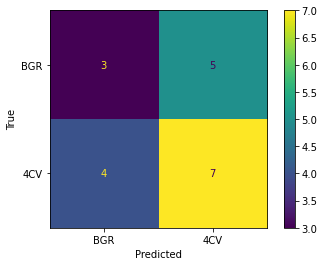

In [7]:
print(classification_report(y_true_list, y_pred_list))
print(confusion_matrix(y_true_list, y_pred_list))

cm=confusion_matrix(y_true_list, y_pred_list)
#cm=confusion_matrix(y_true_list, y_pred_list, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['BGR','4CV'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')


## File size of models: 
```
:~/repositories/echocardiography/models$ tree -s
.
├── [  201010447]  metric_model.pth
├── [  351538511]  VGG00v00_metric_model.pth
├── [  752946511]  VGG00v01_metric_model.pth
└── [  201010511]  VGG00v02_metric_model.pth

0 directories, 4 files

```